<a href="https://colab.research.google.com/github/Arashghsz/labeling_connected_components_in_brain_image/blob/Master/labeling_connected_components_in_brain_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://arashghsz.com
Personal website

In [ ]:
import cv2 as cv 
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import data
from skimage import io
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from google.colab.patches import cv2_imshow
import skimage
!pip install pydicom
import pydicom

     |████████████████████████████████| 2.0 MB 3.7 MB/s 


# Read data from folders

In [ ]:
def read_data(path):
  folder_dir = path
  dcom_ds = []
  for directory_path in glob.glob(folder_dir):
      for folder_dir in glob.glob(os.path.join(directory_path, "*.dcm")):
          img = pydicom.dcmread(folder_dir)       
          dcom_ds.append(img)
  return dcom_ds

In [ ]:
person0_path = '/content/drive/MyDrive/Multi-Media-p1/Brain/00000'
person1_path = '/content/drive/MyDrive/Multi-Media-p1/Brain/00001'
person2_path = '/content/drive/MyDrive/Multi-Media-p1/Brain/00002'
person3_path = '/content/drive/MyDrive/Multi-Media-p1/Brain/00003'


person0_files = []
person1_files = []
person2_files = []
person3_files = []
for i in read_data(person0_path):
    person0_files.append(read_data(person0_path))
for i in read_data(person1_path):
    person1_files.append(read_data(person1_path))
for i in read_data(person2_path):
    person2_files.append(read_data(person2_path))
for i in read_data(person3_path):
    person3_files.append(read_data(person3_path))


# Dataset length 

In [ ]:
print("  we have ", len(person0_files), "data for person #1.\n ",
"we have ", len(person1_files), "data for person #2.\n ",
"we have ", len(person2_files), "data for person #3.\n ",
"we have ", len(person3_files), "data for person #4.\n ")


  we have  49 data for person #1.
  we have  21 data for person #2.
  we have  20 data for person #3.
  we have  63 data for person #4.
 


# WORK WITH ONE DATA
just for less confusing!

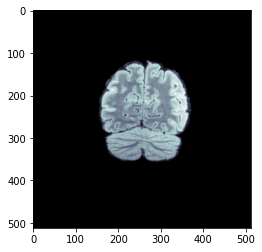

In [ ]:
base = r"/content/drive/MyDrive/Multi-Media-p1/Brain/00000/"
pass_dicom = "Image-107.dcm"

filename = pydicom.data.data_manager.get_files(base, pass_dicom)[0]
ds = pydicom.dcmread(filename)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
plt.show()

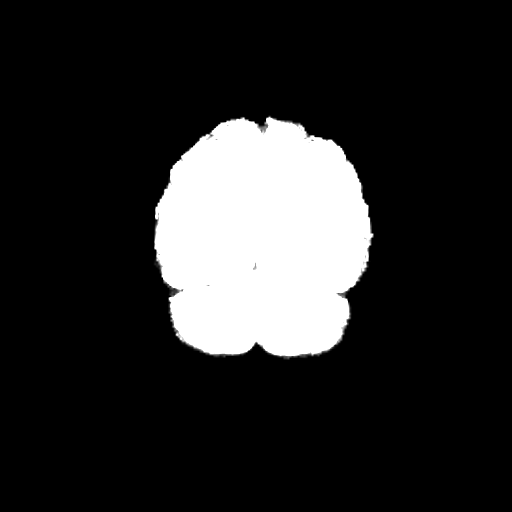

In [ ]:
ds1 = ds.pixel_array
cv2_imshow(ds1)

In [ ]:
ds.pixel_array.shape

(512, 512)

In [ ]:
# ds.PixelData 

In [ ]:
arr = ds.pixel_array
arr[arr < 300] = 0
ds.PixelData = arr.tobytes()
ds.save_as("temp.dcm")

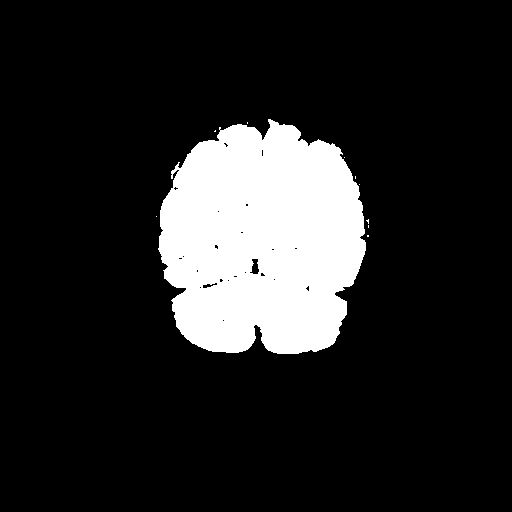

In [ ]:
ret, thresh1 = cv.threshold(ds1, 575, 575, cv.THRESH_BINARY)
cv2_imshow(thresh1)
   
# De-allocate any associated memory usage 
if cv.waitKey(0) & 0xff == 27:
    cv.destroyAllWindows()

In [ ]:
# convert the image to grayscale
gray_image = skimage.color.rgb2gray(ds1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  


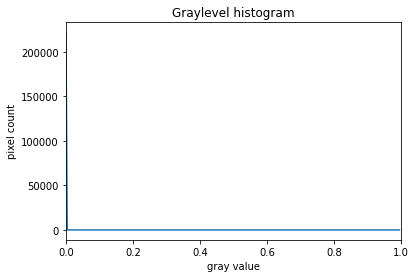

In [ ]:
# show the histogram of the blurred image
histogram, bin_edges = np.histogram(gray_image, bins=256, range=(0.0, 1.0))
fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Graylevel histogram")
plt.xlabel("gray value")
plt.ylabel("pixel count")
plt.xlim(0, 1.0)
plt.show()

In [ ]:
np.max(ds1)
# np.min(ds1)

1785

In [ ]:
# perform automatic thresholding
tr = skimage.filters.threshold_otsu(ds1)
print("Found automatic threshold t = {}.".format(tr)) 

Found automatic threshold t = 577.


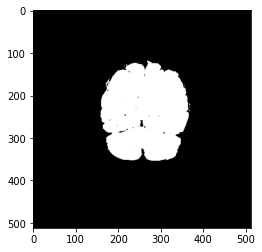

In [ ]:
# create a binary mask with the threshold found by Otsu's method
binary_mask = ds1 > tr

fig, ax = plt.subplots()
plt.imshow(binary_mask, cmap='gray')
plt.show()

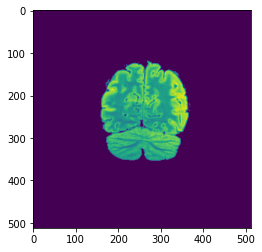

In [ ]:
# apply the binary mask to select the foreground
selection = ds1.copy()
selection[~binary_mask] = 0

fig, ax = plt.subplots()
plt.imshow(selection)
plt.show()

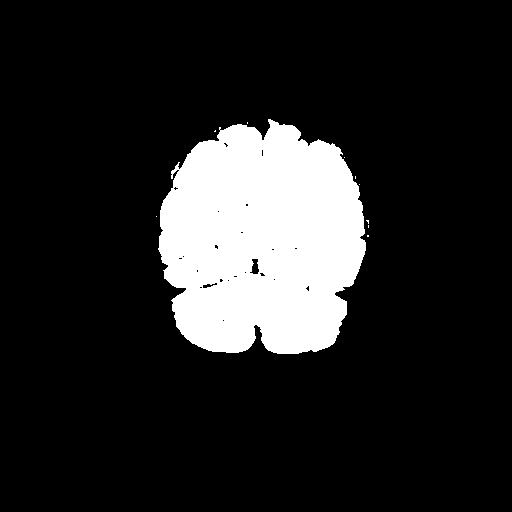

In [ ]:
cv2_imshow(selection)

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


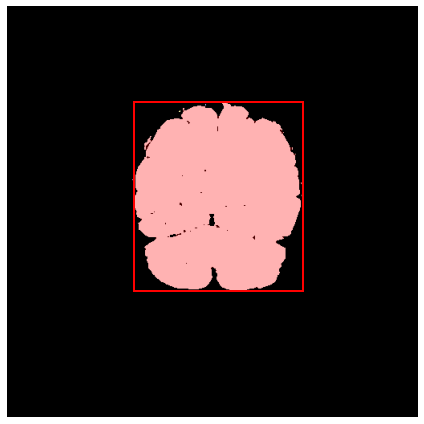

In [ ]:
image = binary_mask
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

cleared = clear_border(bw)
label_image = label(cleared)
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    if region.area >= 100:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

# Try to cut the brain from dcom file

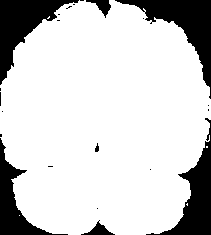

In [ ]:
image = ds.pixel_array
  
# Convert image to array
image_arr = np.array(image)
# cut with numpy
image_arr = image_arr[minr:maxr ,minc:maxc]
cv2_imshow(image_arr)

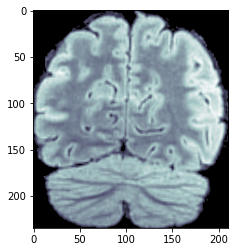

In [ ]:
plt.imshow(image_arr, cmap=plt.cm.bone)  # set the color map to bone
plt.show()

# **Final result on subplot**

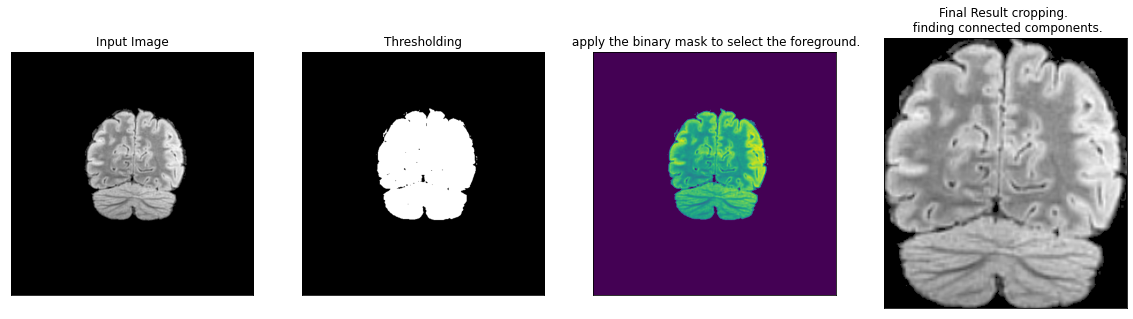

In [ ]:
plt.figure(figsize=([20, 20]))
plt.subplot(141),plt.imshow(ds.pixel_array, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(142),plt.imshow(binary_mask, cmap = 'gray')
plt.title('Thresholding'), plt.xticks([]), plt.yticks([])
plt.subplot(143),plt.imshow(selection)
plt.title(' apply the binary mask to select the foreground.'), plt.xticks([]), plt.yticks([])
plt.subplot(144),plt.imshow(image_arr, cmap="gray")
plt.title('Final Result cropping. \n finding connected components.'), plt.xticks([]), plt.yticks([])
plt.show()